In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader, random_split
import re, os
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
tokenizer = get_tokenizer('basic_english')

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
class CommentDataset(Dataset):
    def __init__(self, folder_path, train=False, test=False, valid=False):
        
        if (train==False and test==False and valid==False):
            raise Exception('One of the `train`, `test` or `valid` needs to be True, got `train = {}` `test = {}` and `valid = {}`'.format(train, test, valid))
        if (train==True and test==True and valid == True):
            raise Exception('Only one of the `train`, `test` or `valid` needs to be True, got `train = {}` `test = {}` and `valid = {}`'.format(train, test, valid))
        if (train==True and test==True):
            raise Exception('Only one of the `train` or `test` needs to be True, got `train = {}`, and `test = {}`'.format(train, test))
        if (train==True and valid==True):
            raise Exception('Only one of the `train` or `valid` needs to be True, got `train = {}`, and `valid = {}`'.format(train, valid))
        if (test==True and valid==True):
            raise Exception('Only one of the `test` or `valid` needs to be True, got `test = {}`, and `valid = {}`'.format(test, valid))

        self.train_df = None
        self.test_df = None
        self.valid_df = None

        # boolean values
        self.train = train
        self.test = test
        self.valid = valid

        self.data_selected = None
        self.comment_selected = None
    
        self.train_comment = []
        self.test_comment = []
        self.val_comment = []
    
        # Read the dataset
        self.data = pd.read_csv(folder_path, sep = ",")#.head(20)
        
        self.data = shuffle(self.data)
        self.data.reset_index(inplace=True, drop=True)
        
        self.data['Annot'].replace('LEFT', 0, inplace=True)
        self.data['Annot'].replace('RIGHT', 1, inplace=True)
        
        # split the dataset into train, test, and valid.
        self.train_df, test_df = train_test_split(self.data, test_size=0.2,  random_state=11)
        self.test_df, self.valid_df = train_test_split(test_df, test_size=0.5,  random_state=96)
        
        if self.train == True:
            # do the sorting
            # Sort the dataframe according to the number of comments on documents.
            self.train_df.sort_values(by=['Number of Comment'], ascending=False, inplace=True)       
            comments = []
            for com in self.train_df["comment"]:
                comments.append(com.replace(" -|- ", "."))
            self.train_comment = comments
            
        elif self.test == True:
            # no need to sort
            comments = []
            for com in self.test_df["comment"]:
                comments.append(com.replace(" -|- ", "."))
            self.test_comment = comments
        elif self.valid == True:
            # no need to sort
            comments = []
            for com in self.valid_df["comment"]:
                comments.append(com.replace(" -|- ", "."))
            self.val_comment = comments

    def __getitem__(self, idx):
        if self.train == True:
            self.data_selected = self.train_df
            self.comment_selected = self.train_comment

        elif self.test == True:
            self.data_selected = self.test_df
            self.comment_selected = self.test_comment

        elif self.valid == True:
            self.data_selected = self.valid_df
            self.comment_selected = self.val_comment

        label = self.data_selected.iloc[idx]["Annot"]
        sentence = self.comment_selected[idx]
        return sentence, label

    def __len__(self):
        
        
        if self.train == True:
            len_ = len(self.train_comment)

        elif self.test == True:
            len_ = len(self.test_comment)

        elif self.valid == True:
            len_ = len(self.val_comment)

        return len_

In [4]:
data_folder = "12. Subscription Training Data.csv"

dataset_train = CommentDataset(data_folder, train=True, test=False, valid=False)
dataset_test = CommentDataset(data_folder, train=False, test=True, valid=False)
dataset_valid = CommentDataset(data_folder, train=False, test=False, valid=True)

In [5]:
def yield_tokens(data_iter):
    for sentence, _ in data_iter:
        yield tokenizer(sentence)

In [6]:
# create vocabulary from the training data.
vocab = build_vocab_from_iterator(yield_tokens(dataset_train), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [7]:
vocab_size = len(vocab.get_itos()) # len(vocab.get_stoi()) - length of the vocabulary
vocab_size

32822

In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
# works perfectly. backup
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(torch.tensor(label_pipeline(_label), dtype=torch.int64 ))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    
    text_list = pad_sequence(text_list, batch_first=False, padding_value = vocab_size-1)
   
    # convert a list of tensors to tensors.
    # input : a list of tensors of len BATCH_SIZE
    label_list = torch.stack(label_list)   
    # OUTPUT shape: [BATCH_SIZE]
    
    return text_list.to(device), label_list.to(device)

In [12]:
# BATCH SAMPLER

In [13]:
from torch.utils.data.sampler import BatchSampler
import numpy as np

In [14]:
from torch.utils.data.sampler import BatchSampler
import numpy as np

class YoutubeBatchSampler(BatchSampler):
    def __init__(self, dataset, num_of_liberals, num_of_conservatives):
        
        self.label_list = []
        for _, label in dataset:
            self.label_list.append(label)

        self.label_list = torch.LongTensor(self.label_list) # list of all the labels in the dataset
        
        self.label_set = list(set(self.label_list.numpy())) # unique labels from the dataset

        self.label_to_indices = {label: np.where(self.label_list.numpy() == label)[0]
                                 for label in self.label_set}

        for l in self.label_set:
            np.random.shuffle(self.label_to_indices[l])

        self.used_label_indices_count = {label: 0 for label in self.label_set}
        self.count = 0
        self.dataset = dataset
        self.num_of_liberals = num_of_liberals
        self.num_of_conservatives = num_of_conservatives
        self.batch_size = self.num_of_liberals + self.num_of_conservatives

    def __iter__(self):
        self.count = 0
        
        # maybe add <= 
        while self.count + self.batch_size < len(self.dataset):
            classes = np.array([1, 0])
            indices = []
            for class_ in classes:
                if(class_ == 0) :
                    indices.extend(self.label_to_indices[class_][self.used_label_indices_count[class_] : self.used_label_indices_count[class_] + self.num_of_liberals])
                    self.used_label_indices_count[class_] += self.num_of_liberals

                    if self.used_label_indices_count[class_] + self.num_of_liberals > len(self.label_to_indices[class_]):
                        np.random.shuffle(self.label_to_indices[class_])
                        self.used_label_indices_count[class_] = 0
              
                elif(class_ == 1):
                    indices.extend(self.label_to_indices[class_][self.used_label_indices_count[class_] : self.used_label_indices_count[class_] + self.num_of_conservatives])
                    self.used_label_indices_count[class_] += self.num_of_conservatives

                    if self.used_label_indices_count[class_] + self.num_of_conservatives > len(self.label_to_indices[class_]):
                        np.random.shuffle(self.label_to_indices[class_])
                        self.used_label_indices_count[class_] = 0
              
              
            yield indices
            self.count = self.count + self.num_of_conservatives + self.num_of_liberals
            
    def __len__(self):
        return len(self.dataset) // self.batch_size

In [15]:
BATCH_SIZE = 32
#num_of_liberals = int(BATCH_SIZE / 2)
#num_of_conservatives = int(BATCH_SIZE - num_of_liberals)
#batch_sampler_train = YoutubeBatchSampler(dataset_train, num_of_liberals, num_of_conservatives)
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)
val_dataloader = DataLoader(dataset_valid,
                              shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(dataset_test,
                              shuffle=False, collate_fn=collate_batch)

In [35]:
class UserClassificationModel(nn.Module):

    def __init__(self, VOCAB_SIZE, EMBEDDING_DIMENSION, num_class, ENCODER_HIDDEN_DIMENSION, embedding_matrix):
        super().__init__()
        
        self.vocab_size = VOCAB_SIZE
        self.embed_dim = EMBEDDING_DIMENSION
        
        self.encoder_hidden_dim = ENCODER_HIDDEN_DIMENSION
        
        self.num_class = num_class

        if USE_PRETRAINED_EMBEDDING_MATRIX:
            self.vocab_size = embedding_matrix.shape[0]
            self.embed_dim = embedding_matrix.shape[1]
            
            self.embedding = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_dim)
            self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        else:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        
        self.gru = nn.GRU(self.embed_dim, self.encoder_hidden_dim, bidirectional = True)
        
        self.fc1 = nn.Linear(self.encoder_hidden_dim*2, self.num_class)
        
    def forward(self, text):
        
        # input shape: [MAX_LENGTH_OF_THE_SENTENCE_IN_BATCH X BATCH_SIZE] 
        embedded = self.embedding(text)
        # output shape: [MAX_SEQ_LENGTH x BATCH_SIZE x embed_dim]
        
        # input shape: [MAX_SEQ_LENGTH x BATCH_SIZE x embed_dim]
        gru_out, hidden = self.gru(embedded)
        # gru_out shape: [MAX_LENGTH_OF_THE_SENTENCE_IN_BATCH, BATCH_SIZE, ENCODER_HIDDEN_DIMENSION*2]
        # hidden[0] shape: [1, BATCH_SIZE, ENCODER_HIDDEN_DIMENSION]
        # hidden[1] shape: [1, NUM_SENTENCES, ENCODER_HIDDEN_DIMENSION]
        
        # input shape: [BATCH_SIZE, ENCODER_HIDDEN_DIMENSION*2]
        fc1 = self.fc1(gru_out[-1])
        # output shape: [BATCH_SIZE, num_classes]
        
        # input shape: [BATCH_SIZE, Num_class]
        classifier = F.softmax(fc1, dim=1)#.squeeze(1)
        # output shape: [BATCH_SIZE, Num_class]
        
        return classifier

In [22]:
def Download_and_extract():
    print("This might take some time...")
    print("Downloading...")
    os.system('wget https://nlp.stanford.edu/data/glove.840B.300d.zip')
    
    Extract()
    
def Extract():
    print("Extracting...")
    # extract and save to the same directory.
    with zipfile.ZipFile('glove.840B.300d.zip', 'r') as zip_ref:
        zip_ref.extractall("./")
    print("Done!")
    
def load_pretrained_embedding_matrix():
    # Downloadin Glove word vector
    # this might take some time........... ~5 mins.
    if((os.path.isfile('glove.840B.300d.zip') == False)):
        Download_and_extract()
    elif((os.path.isfile('glove.840B.300d.zip') == True) and (os.path.isfile('glove.840B.300d.txt') == False)):
         Extract()
    else:
        print("Already Downloaded and extracted!")

    #!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
    #!unzip glove.840B.300d.zip

# https://github.com/MohammadWasil/Visual-Question-Answering-VQA/blob/master/2.%20Dataset%20Used%20in%20Training..ipynb
def GloveModel(file_path, vocab):
    embedding_index = {}
    f = open(file_path,'r', encoding='utf8')
    embedding_index = {}
    print("Opened!")

    for j, line in enumerate(f):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        embedding_index[word] = embedding
      
    print("Done.",len(embedding_index)," words loaded!")
    EMBEDDING_DIM = 300
    embedding_matrix = np.zeros((len(vocab.get_stoi()) + 1, EMBEDDING_DIM))
    print(embedding_matrix.shape)

    for index, word in enumerate(vocab.get_itos()):
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [18]:
# can change this accordingly.
USE_PRETRAINED_EMBEDDING_MATRIX = False

if USE_PRETRAINED_EMBEDDING_MATRIX:
    # download an dextract the glove embedding if they're not.
    load_pretrained_embedding_matrix()
    # load the embedding matrix.
    embedding_matrix = GloveModel("glove.840B.300d.txt", vocab)
else:
    embedding_matrix = None

In [46]:
num_class = 2
embedding_size = 100
ENCODER_HIDDEN_DIMENSION = 64

model = UserClassificationModel(vocab_size, embedding_size, num_class, ENCODER_HIDDEN_DIMENSION, embedding_matrix).to(device)

def train(model, train_dataloader):
    optimizer = Adam(model.parameters(), 0.0001)
    loss_function = nn.CrossEntropyLoss()

    train_loss_list = []
    val_loss_list = []
    train_accu_list = []
    val_accu_list = []

    for epoch in range(0, 3):
        model.train()
        model.to(device)
        train_loss = 0
        
        accuracy = 0
        
        for idx, (text, label) in enumerate(train_dataloader):
            optimizer.zero_grad()

            predicted_label = model(text)
            
            loss = loss_function(predicted_label, label)

            loss.backward()
            optimizer.step()
            
            #prediction = predicted_label#.argmax(1)#.item()
            actual = label.reshape(-1)
            
            predicted_label = torch.argmax(predicted_label, dim=1 ) 
            accuracy += torch.eq(predicted_label, actual).sum().item()

            train_loss += loss.item()
        train_loss = train_loss / len(train_dataloader)
        accuracy = accuracy * 100.0 / len(dataset_train)

        EPOCH_VAL_ACC, EPOCH_VAL_LOSS, F1_score = evaluate(val_dataloader, model, loss_function)

        print(f'Epoch: {epoch+1} | Train Loss: {train_loss} | Accuracy: {accuracy} | Val Accuracy: {EPOCH_VAL_ACC} | Val Loss: {EPOCH_VAL_LOSS} | F1 Score: {F1_score}')
        train_loss_list.append(train_loss)
        val_loss_list.append(EPOCH_VAL_LOSS)
        train_accu_list.append(accuracy)
        val_accu_list.append(EPOCH_VAL_ACC)
        
    return train_loss_list, val_loss_list, train_accu_list, val_accu_list


In [48]:
def evaluate(val_dataloader, model, loss_function):
    model.eval()
    correct = 0
    total_count = 0

    # for f1 score
    prediction_labels = []
    actual_labels = []

    val_loss = 0

    with torch.no_grad():    
        for text, label in val_dataloader:
            text = text.to(device)
            label = label.to(device)
            
            # feed the validation text into the model, and get the probabilities.
            predicted_label = model(text)

            # calculate loss
            loss = loss_function(predicted_label, label)
            
            # validation accuracy
            actual = label.reshape(-1)
            predicted_label = torch.argmax(predicted_label, dim=1 ) 
            correct += torch.eq(predicted_label, actual).sum().item()

            # to cal f1 score.
            prediction_labels.append(predicted_label)
            actual_labels.append(actual)   

            # convert probabilities into 0/1.
            #predicted_label = torch.round(predicted_label).type(torch.int64)
            
            # count the number of correctly predicted labels.
            #correct += torch.eq(predicted_label, label).sum().item()
            
            # get the total length of the sentences in val_dataloader
            #total_count += label.size(0)

            val_loss += loss.item()
        val_loss = val_loss / len(val_dataloader)

        # convert unequal length of lists of tensors to on single tensors.
        #actual_labels = torch.flatten(torch.stack(actual_labels)) 
        actual_labels = torch.cat(actual_labels).to('cpu')
        #prediction_labels = torch.flatten(torch.stack(prediction_labels)) 
        prediction_labels = torch.cat(prediction_labels).to('cpu')
        
        F1_score = f1_score(actual_labels, prediction_labels)
        
    # returns the accuracy of the model
    return correct * 100.0 / len(dataset_valid), val_loss, F1_score

In [47]:
train_loss_list, val_loss_list, train_accu_list, val_accu_list = train(han_model, train_dataloader)

tensor([0, 1, 1,  ..., 1, 0, 0]) : tensor([0, 0, 0,  ..., 0, 0, 0])
Epoch: 1 | Train Loss: 0.6692756467227694 | Accuracy: 60.59674861221253 | Val Accuracy: 62.044374009508715 | Val Loss: 0.6644521590599735 | F1 Score: 0.0
tensor([0, 1, 1,  ..., 1, 0, 0]) : tensor([0, 0, 0,  ..., 0, 0, 0])
Epoch: 2 | Train Loss: 0.6700526404229901 | Accuracy: 60.59674861221253 | Val Accuracy: 62.044374009508715 | Val Loss: 0.6638931219485218 | F1 Score: 0.0
tensor([0, 1, 1,  ..., 1, 0, 0]) : tensor([0, 0, 0,  ..., 0, 0, 0])
Epoch: 3 | Train Loss: 0.669942604024199 | Accuracy: 60.59674861221253 | Val Accuracy: 62.044374009508715 | Val Loss: 0.6640611524957862 | F1 Score: 0.0


In [49]:
loss_function = nn.CrossEntropyLoss()
TEST_ACC, TEST_LOSS, F1_score = evaluate(test_dataloader, han_model, loss_function = nn.CrossEntropyLoss())
print("The test accuracy is: {:.2f}%".format(TEST_ACC))
print("F1 Score on Test data is: {:.2f}".format(F1_score))
print("Loss on Test Data is: {:.2f}".format(TEST_LOSS))

The test accuracy is: 59.75%
F1 Score on Test data is: 0.00
Loss on Test Data is: 0.68


ValueError: x and y must have same first dimension, but have shapes (20,) and (3,)

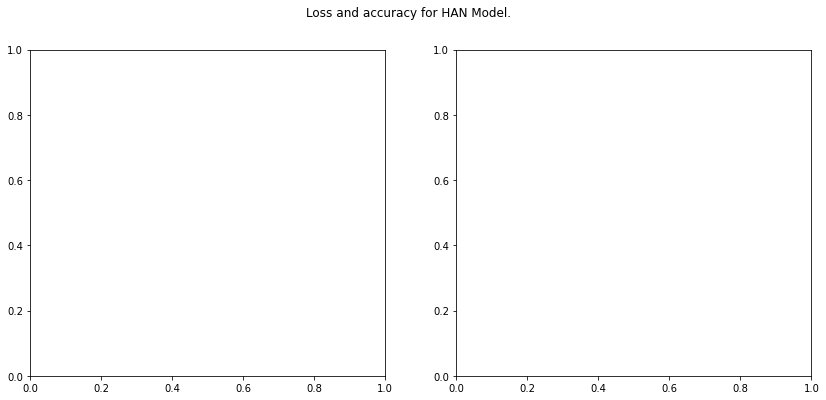

In [50]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fig, (ax1) = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Loss and accuracy for HAN Model.')

epochs = 30 + 1

# accuracy Plot
train_accu, = ax1[0].plot(range(1, epochs), train_accu_list, label="Training Accuracy")  
val_accu, = ax1[0].plot(range(1, epochs), val_accu_list, label="Validation Accuracy")  

ax1[0].legend(handles=[train_accu, val_accu])
ax1[0].set_xlabel("Epochs")
ax1[0].set_ylabel("Accuracy")
ax1[0].set_title("Accuracy for every Epochs")
ax1[0].set_xticks(range(1, epochs))

train_loss, = ax1[1].plot(range(1, epochs), train_loss_list, label="Training Loss")  
val_loss, = ax1[1].plot(range(1, epochs), val_loss_list, label="Validation Loss")  

ax1[1].legend(handles=[train_loss, val_loss])
ax1[1].set_xlabel("Epochs")
ax1[1].set_ylabel("Loss")
ax1[1].set_title("Loss for every Epochs")
ax1[1].set_xticks(range(1, epochs))

# do not need the third plot.
#fig.delaxes(ax2[1])

plt.show()